# Workshop 4 - Resnets

**Remember to save a copy to your own drive!!**

In [ ]:
# Import libraries
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torch import optim

from fastai.vision import untar_data, URLs

import os, sys
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Get device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Dataset and Transforms
Fastai has some [interesting datasets](https://course.fast.ai/datasets) that we can download and use for practice or for benchmarking. Today we'll be working with ImageWoof which is a subset of 10 classes from ImageNet that are all dog breeds.

In [ ]:
# Download the dataset and store the path
path = untar_data(URLs.IMAGEWOOF)

In [ ]:
# If you haven't seen python path objects, they're just a simpler way to work with addresses.
print("Type:", type(path))
print("Path", path)
print(path/"some"/"directory")

Type: <class 'pathlib.PosixPath'>
Path /root/.fastai/data/imagewoof2
/root/.fastai/data/imagewoof2/some/directory


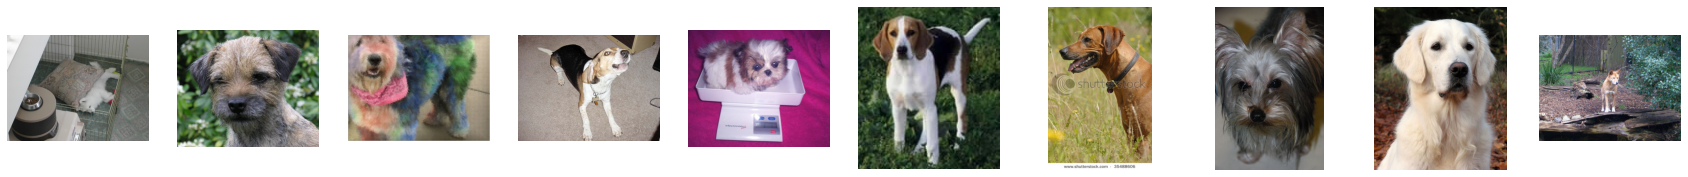

In [ ]:
# Plot the data to get an idea of our samples
size = 3
num = 10
f, axs = plt.subplots(1, num, figsize=(size * num, size))

# Get all classnames
classnames = os.listdir(path/"train")


for i, classname in enumerate(classnames):
    # Get image path
    filename = os.listdir(path/"train"/classname)[0]
    image_path = path/"train"/classname/filename
    
    # Plot image
    plt.subplot(1, num, i + 1)
    img = Image.open(image_path)
    plt.axis('off')
    plt.imshow(img)

The dataset is composed of coloured images, all with different sizes. We will need to use transforms to standardise the input size for our model. Similarly, we will also want to convert our inputs to a PyTorch tensor and to normalise it, so that our model can better handle the inputs. We can also use augmentations to stretch our data further, changing the inputs as we load them from memory.

The list of PyTorch transforms is available on their [documentation](https://pytorch.org/docs/stable/torchvision/transforms.html).

In [ ]:
# Define transforms for the training set

# Resize the image to a 256x216 image
# Add a random horizontal flip
# Randomly crop the data to make it square
# Transform the image to a tensor
# Normalise the data with imagenet statistics (means: 0.485, 0.456, 0.406, std: 0.229, 0.224, 0.225)
train_trans = transforms.Compose([transforms.Resize(256, interpolation=2),
                                  transforms.RandomHorizontalFlip(),
                                  transforms.RandomRotation(20),
                                  transforms.RandomCrop(256, pad_if_needed=True, padding_mode="reflect"),
                                  transforms.ToTensor(),
                                  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                  ])

# Copy the training transforms, but only include the transforms that aren't augmentations
valid_trans = transforms.Compose([transforms.Resize(256, interpolation=2),
                                  transforms.CenterCrop(256),
                                  transforms.ToTensor(),
                                  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                  ])

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:281: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [ ]:
# Create the train and validation datasets
# The train / validation split is predetermined in this dataset and divided by folder
train_ds = datasets.ImageFolder(path/"train", transform=train_trans)
valid_ds = datasets.ImageFolder(path/"val", transform=valid_trans)

In [ ]:
# Make dataloaders
bs = 16
nw = 16
train_loader = DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=nw)
valid_loader = DataLoader(valid_ds, batch_size=bs, shuffle=False, num_workers=nw)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# Training loops
### Exercise: Complete the training and validation loop in the functions below. Look at the previous workshop if you need a hint.

In [ ]:
def train(model, train_loader, loss_fn, optimizer, device):
    # Prepare for training
    model.train()
    running_loss = 0
  
    with tqdm(total=len(train_loader)) as pbar:
        for inputs, labels in train_loader:
            # Put images and labels on GPU
            inputs, labels = inputs.to(device), labels.to(device)

            # Run through model and update
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()          

            # Track loss and update progress
            running_loss += loss.item()
            pbar.update(1)

    return running_loss / len(train_loader)

In [ ]:
# Function for the validation pass
def validation(model, val_loader, loss_fn, device):
    # Prepare for validating
    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        with tqdm(total=len(val_loader)) as pbar:
            for images, labels in iter(val_loader):
                # Put images and labels on GPU
                images, labels = images.to(device), labels.to(device)

                # Run through model
                outputs = model(images)

                # Track loss and update progress
                val_loss += loss_fn(outputs, labels).item()

                # Update accuracy
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                pbar.update(1)
            
    return val_loss / len(val_loader), correct / total

# Writing a ResNet
Rather than writing one giant class that handles every thing, we can write more readable code that is easier to maintain by breaking the model up into several smaller classes

Every time that we use a convolution, we usually want to activate it with `BatchNorm` and `ReLU`. A ResNet is also composed mostly of 3x3 convolutions that maintain the input dimensions (`ks=3`, `stride=1` and `pad=1`).

### Exercise: Complete the `Conv3x3` class to run a convolution, then optionally `BatchNorm` and `ReLU`.

In [ ]:
# Convolution, batch norm, ReLu with typical parameters defaulted
class Conv(nn.Module):
    def __init__(self, in_planes, out_planes, ks=3, stride=1, pad=1, bn=True, activ=True):
        super().__init__()
        # The main convolution
        # Use nn.Conv2d to define a convolution layer with the parameters specified
        self.conv = nn.Conv2d(in_planes, out_planes, ks, stride, pad)

        # Optionally include activations
        # If BatchNorm is True, use nn.BatchNorm2d to include a Batch Normalisation
        if bn:
          self.bn = nn.BatchNorm2d(out_planes)
        else:
          self.bn = None
        # If activ is True, use nn.ReLU to include a ReLU

        if activ:
          self.activ = nn.ReLU()
        else:
          self.activ = None
          

    def forward(self, x):
        # Run through convolution then BatchNorm then ReLU
        
        h = self.conv(x)
        if self.bn is not None:
          h = self.bn(h)
        
        if self.activ is not None:
          h = self.activ(h)
        
        return h


![alt text](https://mohitjainweb.files.wordpress.com/2018/06/bottleneck-layer-resnet1.png?w=700)

A ResNet uses one of two types of repeating blocks, the `Basic Block` and the `Bottleneck Block`. The Basic Block is simpler and simply has two 3x3 convolutions and a skip connection, it is used in ResNet 18 and ResNet 34. The Bottleneck Block is uses a 1x1 convolution .

These blocks can also be used to downsample by increasing the stride to 2 on the first 3x3 convolution and adding a single 3x3 convolution to 'fix' the dimensions on the skip connection.

### Exercise: Using the `Conv` class we've just made, complete the `Basic Block` class to run a double convolution with a skip connection. You can use the Bottleneck class as an example if you need to.

In [ ]:
# ResNet Basic Block
class BasicBlock(nn.Module):
    def __init__(self, in_planes, out_planes, downsample=False):
        super(BasicBlock, self).__init__()

        # If downsample is True, we will downsample with a stride 2 convolution
        self.downsample = downsample
        if self.downsample:
            # Use the Conv class to downsample, changing the number of filters to out_planes
            self.conv1 = Conv(in_planes, out_planes, stride=2, pad=2)

            # We will also need a convolution to downsample on the skip connection to 'fix' the dimensions
            # Use the Conv class to downsample without ReLU
            self.conv_skip1 = Conv(in_planes, out_planes, activ=False, stride=2, pad=2)

        # If downsample is False, we can just use the default settings of our Conv class
        else:
            # Use the Conv class, changing the number of filters to out_planes

            self.conv1 = Conv(in_planes, out_planes)

        

        # The second convolution doesn't use ReLU since this is applied after the skip connection
        # Use the Conv class without ReLU

        self.conv2 = Conv(out_planes, out_planes, activ=False)

        # Define a ReLU activation

        self.relu = nn.ReLU()

    def forward(self, x):
        # Save original or downsample
        if self.downsample:
          original_x = self.conv_skip1(x)
        else:
          original_x = x

        # Double convolution
        out = self.conv1(x)
        out = self.conv2(out)

        # Apply skip connection and final activation
        out = out + original_x
        out = self.relu(out)

        return out


In [ ]:
# ResNet Bottleneck Block
class Bottleneck(nn.Module):
    def __init__(self, in_planes, out_planes, downsample=False):
        super(Bottleneck, self).__init__()
        
        # Reduce planes in the centre of the bottleneck by a factor of 4
        reduced_planes = out_planes // 4
        
        # Reduce planes with a 1x1 convolution
        self.conv1 = Conv(in_planes, reduced_planes, ks=1, pad=0)
        
        # Downsampling uses a stride 2 conv
        self.downsample = downsample
        
        # If downsample is True, we will downsample with a stride 2 convolution
        if self.downsample:
            self.conv2 = Conv(reduced_planes, reduced_planes, stride=2, pad=1)
            
            # We will also need a convolution to downsample on the skip connection
            self.downsample = Conv(in_planes, out_planes, ks=1, stride=2, activ=None)
        
        # If downsample is False, we can just use the default settings of our Conv class
        else:
            self.conv2 = Conv(reduced_planes, reduced_planes)
        
        # Increase planes with a 1x1 convolution
        self.conv3 = Conv(reduced_planes, out_planes, ks=1, pad=0, activ=None)

        
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        # Save original or downsample
        identity = self.downsample(x) if self.downsample else x

        # Triple convolution
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        
        # Apply skip connection and final activation
        out += identity
        out = self.relu(out)

        return out

<img src=https://cdn-images-1.medium.com/max/2400/1*6hF97Upuqg_LdsqWY6n_wg.png style="margin-bottom: -270px;">

A `ResNet` can be decomposed into its input transition, the middle layers and its output transition:
- The input transition uses a 7x7 convolution and a 3x3 max pool with a stride of 2. 
- The four 'middle layers' use repeating blocks with the first convolution downsampling. Though, since the input transition downsamples, the first middle layer will not downsample.
- The output transition uses an average pool to take the average of each filter, then flattens the collected features to remove excess dimensions and passes this into a fully connected network

### Exercise: Complete the `ResNet` class below.

In [ ]:
# A ResNet Model that 
class ResNet(nn.Module):
    def __init__(self, block, depths, num_classes):
        super(ResNet, self).__init__()
        self.block = block
        self.depths = depths

        # Input transition
        self.in1 = Conv(3, 64, ks=7, stride=2, pad=3)
        self.in2 = nn.MaxPool2d(2)
        
        # Downsample path
        self.down1 = self._make_layer(64, 64, depths[0], downsample=False)
        self.down2 = self._make_layer(64, 128, depths[1])
        self.down3 = self._make_layer(128, 256, depths[2])
        self.down4 = self._make_layer(256, 512, depths[3])

        # Output transition
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.flatten = nn.Flatten(start_dim=1)
        self.fc = nn.Linear(in_features=512, out_features=num_classes)

    # Create a middle layer
    def _make_layer(self, in_channels, out_channels, depth, downsample=True):
        # Increase the number of filters
        layers = [self.block(in_channels, out_channels, downsample=downsample)]

        # Add a repeat the block depth - 1 times
        for _ in range(depth - 1):
            layers.append(self.block(out_channels, out_channels))

        # Convert the layers list into a Sequential
        return nn.Sequential(*layers)

    def forward(self, x):
        # Input

        h = self.in1(x)
        h = self.in2(h)

        # Downsample

        h = self.down1(h)
        h = self.down2(h)
        h = self.down3(h)
        h = self.down4(h)
        
        # Output
        h = self.avg_pool(h)
        h = self.flatten(h)
        h = self.fc(h)
        
        return h

In [ ]:
# Define a series of functions to make each ResNet
def resnet18(num_classes): return ResNet(BasicBlock, [2, 2, 2, 2], num_classes)
def resnet34(num_classes): return ResNet(BasicBlock, [3, 4, 6, 3], num_classes)
def resnet50(num_classes): return ResNet(Bottleneck, [3, 4, 6, 3], num_classes)
def resnet101(num_classes): return ResNet(Bottleneck, [3, 4, 23, 3], num_classes)
def resnet152(num_classes): return ResNet(Bottleneck, [3, 8, 36, 3], num_classes)

Compare our ResNet with PyTorch's ResNet. We've broken down the class differently and used different layer names, but the model's structure should be the same.

In [ ]:
resnet18(1000)

ResNet(
  (in1): Conv(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activ): ReLU()
  )
  (in2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down1): Sequential(
    (0): BasicBlock(
      (conv1): Conv(
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activ): ReLU()
      )
      (conv2): Conv(
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU()
    )
    (1): BasicBlock(
      (conv1): Conv(
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [ ]:
models.resnet18()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Testing the Model
Finally let's train our model to see how it goes. Feel free to experiment with the other ResNets to see how they differ in performance. If everything has worked as intended, it should approach the performance of a ResNet without pretraining.

In [ ]:
model = resnet34(10).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0003)

In [ ]:
total_epoch = 20

for epoch in range(total_epoch):
    # Train the model for one epoch
    train_loss = train(model, train_loader, loss_fn, optimizer, device)
    # Calculate validation metrics for one epoch
    val_loss, accuracy = validation(model, valid_loader, loss_fn, device)
    print("Epoch: {}/{}, Training Loss: {:.4f}, Val Loss: {:.4f}, Val Accuracy: {:.4f}".format(epoch+1, total_epoch, train_loss, val_loss, accuracy))
    print('-' * 20)

print("Finished Training")

  0%|          | 0/565 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


  0%|          | 0/246 [00:00<?, ?it/s]

Epoch: 1/20, Training Loss: 2.1966, Val Loss: 2.1204, Val Accuracy: 0.2288
--------------------


  0%|          | 0/565 [00:00<?, ?it/s]

  0%|          | 0/246 [00:00<?, ?it/s]

Epoch: 2/20, Training Loss: 2.0587, Val Loss: 2.0576, Val Accuracy: 0.2632
--------------------


  0%|          | 0/565 [00:00<?, ?it/s]

  0%|          | 0/246 [00:00<?, ?it/s]

Epoch: 3/20, Training Loss: 1.9091, Val Loss: 2.3902, Val Accuracy: 0.2006
--------------------


  0%|          | 0/565 [00:00<?, ?it/s]

  0%|          | 0/246 [00:00<?, ?it/s]

Epoch: 4/20, Training Loss: 1.7875, Val Loss: 2.2831, Val Accuracy: 0.3039
--------------------


  0%|          | 0/565 [00:00<?, ?it/s]

  0%|          | 0/246 [00:00<?, ?it/s]

Epoch: 5/20, Training Loss: 1.6794, Val Loss: 1.7534, Val Accuracy: 0.3942
--------------------


  0%|          | 0/565 [00:00<?, ?it/s]

  0%|          | 0/246 [00:00<?, ?it/s]

Epoch: 6/20, Training Loss: 1.5855, Val Loss: 1.6775, Val Accuracy: 0.4088
--------------------


  0%|          | 0/565 [00:00<?, ?it/s]

  0%|          | 0/246 [00:00<?, ?it/s]

Epoch: 7/20, Training Loss: 1.4743, Val Loss: 1.5738, Val Accuracy: 0.4421
--------------------


  0%|          | 0/565 [00:00<?, ?it/s]

  0%|          | 0/246 [00:00<?, ?it/s]

Epoch: 8/20, Training Loss: 1.3878, Val Loss: 1.3370, Val Accuracy: 0.5353
--------------------


  0%|          | 0/565 [00:00<?, ?it/s]

  0%|          | 0/246 [00:00<?, ?it/s]

Epoch: 9/20, Training Loss: 1.2885, Val Loss: 1.5260, Val Accuracy: 0.4737
--------------------


  0%|          | 0/565 [00:00<?, ?it/s]

  0%|          | 0/246 [00:00<?, ?it/s]

Epoch: 10/20, Training Loss: 1.2239, Val Loss: 1.0951, Val Accuracy: 0.6304
--------------------


  0%|          | 0/565 [00:00<?, ?it/s]

  0%|          | 0/246 [00:00<?, ?it/s]

Epoch: 11/20, Training Loss: 1.1457, Val Loss: 1.3191, Val Accuracy: 0.5671
--------------------


  0%|          | 0/565 [00:00<?, ?it/s]

  0%|          | 0/246 [00:00<?, ?it/s]

Epoch: 12/20, Training Loss: 1.0855, Val Loss: 1.1096, Val Accuracy: 0.6302
--------------------


  0%|          | 0/565 [00:00<?, ?it/s]

  0%|          | 0/246 [00:00<?, ?it/s]

Epoch: 13/20, Training Loss: 1.0243, Val Loss: 1.0232, Val Accuracy: 0.6610
--------------------


  0%|          | 0/565 [00:00<?, ?it/s]

  0%|          | 0/246 [00:00<?, ?it/s]

Epoch: 14/20, Training Loss: 0.9821, Val Loss: 0.9626, Val Accuracy: 0.6773
--------------------


  0%|          | 0/565 [00:00<?, ?it/s]

  0%|          | 0/246 [00:00<?, ?it/s]

Epoch: 15/20, Training Loss: 0.9119, Val Loss: 1.0621, Val Accuracy: 0.6444
--------------------


  0%|          | 0/565 [00:00<?, ?it/s]

  0%|          | 0/246 [00:00<?, ?it/s]

Epoch: 16/20, Training Loss: 0.8836, Val Loss: 0.9111, Val Accuracy: 0.7050
--------------------


  0%|          | 0/565 [00:00<?, ?it/s]

  0%|          | 0/246 [00:00<?, ?it/s]

Epoch: 17/20, Training Loss: 0.8328, Val Loss: 0.9206, Val Accuracy: 0.7027
--------------------


  0%|          | 0/565 [00:00<?, ?it/s]

  0%|          | 0/246 [00:00<?, ?it/s]

Epoch: 18/20, Training Loss: 0.7876, Val Loss: 0.9264, Val Accuracy: 0.6961
--------------------


  0%|          | 0/565 [00:00<?, ?it/s]

  0%|          | 0/246 [00:00<?, ?it/s]

Epoch: 19/20, Training Loss: 0.7603, Val Loss: 0.8361, Val Accuracy: 0.7348
--------------------


  0%|          | 0/565 [00:00<?, ?it/s]

  0%|          | 0/246 [00:00<?, ?it/s]

Epoch: 20/20, Training Loss: 0.7306, Val Loss: 1.1069, Val Accuracy: 0.6638
--------------------
Finished Training
